# Athena SQL Model

This example will create an athena table for [Jan 2017 taxi dataset](https://aws.amazon.com/blogs/big-data/build-a-data-lake-foundation-with-aws-glue-and-amazon-s3/).  You can improve performance if you convert into a parquet format.

Configure your notebook role with permissions to [query data from athena](https://aws.amazon.com/blogs/machine-learning/run-sql-queries-from-your-sagemaker-notebooks-using-amazon-athena/) and access the s3 staging bucket.

## Install libraries

Install the [Athena library](https://pypi.org/project/PyAthena/) for python and [tqdm](https://tqdm.github.io/)

In [1]:
import sys
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install -q PyAthena
!{sys.executable} -m pip install -q tqdm
!{sys.executable} -m pip install -U sagemaker

     |████████████████████████████████| 1.5 MB 11.0 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
Requirement already up-to-date: sagemaker in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (2.13.0)


### Restart Kernel

Now that you have upgraded SageMaker you need to restart the kernel by clicking menu: `Kernel -> Restart & Clear Output`.

Once restarted, run the next cell to check you have version starting with `2.x`

In [2]:
import sys
!{sys.executable} -m pip show sagemaker

Name: sagemaker
Version: 2.13.0
Summary: Open source library for training and deploying models on Amazon SageMaker.
Home-page: https://github.com/aws/sagemaker-python-sdk/
Author: Amazon Web Services
Author-email: None
License: Apache License 2.0
Location: /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages
Requires: numpy, protobuf3-to-dict, google-pasta, importlib-metadata, boto3, packaging, smdebug-rulesconfig, protobuf
Required-by: 


## Import Data

Create an anthena database and external table for the imported nyc bit dataset.

In [3]:
import boto3
import sagemaker

# Initialize the boto session in us-east-1 region
boto_session = boto3.session.Session(region_name='us-east-1')
region = boto_session.region_name
bucket = sagemaker.session.Session(boto_session).default_bucket()

# Get the athena staging dir andtable
s3_staging_dir = 's3://{}/athena'.format(bucket)
db_name = 'nyc_taxi'
table_name = '{}.taxi_csv'.format(db_name)

print('s3 staging dir: {}'.format(s3_staging_dir))
print('athena table: {}'.format(table_name))

s3 staging dir: s3://sagemaker-us-east-1-769203131176/athena
athena table: nyc_taxi.taxi_csv


Make the bucket if it doesn't exist

In [4]:
!aws s3 mb s3://$bucket --region $region

make_bucket: sagemaker-us-east-1-769203131176


Query the nyc taxi dataset using [PandasCursor](https://pypi.org/project/PyAthena/#pandascursor) for improved performance

In [5]:
from pyathena import connect
from pyathena.pandas_cursor import PandasCursor
import pandas as pd

cursor = connect(s3_staging_dir=s3_staging_dir,
                 region_name=region,
                 cursor_class=PandasCursor).cursor()

In [6]:
sql_ddl_create_table = 'CREATE DATABASE IF NOT EXISTS {};'.format(db_name)

cursor.execute(sql_ddl_create_table)
print('Status: {}, Run time: {:.2f}s'.format(cursor.state, 
    cursor.execution_time_in_millis/1000.0))

Status: SUCCEEDED, Run time: 0.25s


In [7]:
sql_create_table = '''
CREATE EXTERNAL TABLE IF NOT EXISTS `{}` (
    `vendorid` bigint, 
    `lpep_pickup_datetime` string, 
    `lpep_dropoff_datetime` string, 
    `store_and_fwd_flag` string, 
    `ratecodeid` bigint, 
    `pulocationid` bigint, 
    `dolocationid` bigint, 
    `passenger_count` bigint, 
    `trip_distance` double, 
    `fare_amount` double, 
    `extra` double, 
    `mta_tax` double, 
    `tip_amount` double, 
    `tolls_amount` double, 
    `ehail_fee` string, 
    `improvement_surcharge` double, 
    `total_amount` double, 
    `payment_type` bigint, 
    `trip_type` bigint)
ROW FORMAT DELIMITED 
    FIELDS TERMINATED BY ',' 
STORED AS INPUTFORMAT 
    'org.apache.hadoop.mapred.TextInputFormat' 
OUTPUTFORMAT 
    'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION
    's3://aws-bigdata-blog/artifacts/glue-data-lake/data/'
TBLPROPERTIES (
    'columnsOrdered'='true', 
    'compressionType'='none', 
    'skip.header.line.count'='1')
'''.format(table_name)

cursor.execute(sql_create_table)
print('Status: {}, Run time: {:.2f}s'.format(cursor.state, 
    cursor.execution_time_in_millis/1000.0))

Status: SUCCEEDED, Run time: 0.43s


In [8]:
data_sql = '''
SELECT 
    total_amount, fare_amount, lpep_pickup_datetime, lpep_dropoff_datetime, trip_distance 
FROM {} WHERE total_amount is not null;
'''.format(table_name)
print('Querying...', data_sql)

data_df = cursor.execute(data_sql).as_pandas()
print('Status: {}, Run time: {:.2f}s, Data scanned: {:.2f}MB, Records: {:,}'.format(cursor.state, 
    cursor.execution_time_in_millis/1000.0, cursor.data_scanned_in_bytes/1024.0/1024.0, data_df.shape[0]))

data_df.head()

Querying... 
SELECT 
    total_amount, fare_amount, lpep_pickup_datetime, lpep_dropoff_datetime, trip_distance 
FROM nyc_taxi.taxi_csv WHERE total_amount is not null;

Status: SUCCEEDED, Run time: 5.18s, Data scanned: 91.34MB, Records: 1,070,261


,total_amount,fare_amount,lpep_pickup_datetime,lpep_dropoff_datetime,trip_distance
0,20.30,16.5,2017-01-22 21:49:27,2017-01-22 22:07:02,4.74
1,26.16,20.5,2017-01-22 21:52:32,2017-01-22 22:15:40,5.56
2,10.56,7.5,2017-01-22 21:07:23,2017-01-22 21:14:19,1.61
3,12.96,9.5,2017-01-22 21:37:01,2017-01-22 21:46:48,2.28
4,11.16,8.0,2017-01-22 21:55:06,2017-01-22 22:03:13,1.71


Performance some simple feature engineering

In [9]:
# Add some date features
data_df['lpep_pickup_datetime'] = data_df['lpep_pickup_datetime'].astype('datetime64[ns]')
data_df['lpep_dropoff_datetime'] = data_df['lpep_dropoff_datetime'].astype('datetime64[ns]')
data_df['duration_minutes'] = (data_df['lpep_dropoff_datetime'] - data_df['lpep_pickup_datetime']).dt.seconds/60
data_df['hour_of_day'] = data_df['lpep_pickup_datetime'].dt.hour
data_df['day_of_week'] = data_df['lpep_pickup_datetime'].dt.dayofweek
data_df['week_of_year'] = data_df['lpep_pickup_datetime'].dt.weekofyear
data_df['month_of_year'] = data_df['lpep_pickup_datetime'].dt.month

In [10]:
# Exclude any outliers
data_df = data_df[(data_df.total_amount > 0) & (data_df.total_amount < 200) & 
                  (data_df.duration_minutes > 0) & (data_df.duration_minutes < 120) & 
                  (data_df.trip_distance > 0) & (data_df.trip_distance < 1000)].dropna()
print(data_df.shape)
data_df.head()

(1046381, 10)


,total_amount,fare_amount,lpep_pickup_datetime,lpep_dropoff_datetime,trip_distance,duration_minutes,hour_of_day,day_of_week,week_of_year,month_of_year
0,20.30,16.5,2017-01-22 21:49:27,2017-01-22 22:07:02,4.74,17.583333,21,6,3,1
1,26.16,20.5,2017-01-22 21:52:32,2017-01-22 22:15:40,5.56,23.133333,21,6,3,1
2,10.56,7.5,2017-01-22 21:07:23,2017-01-22 21:14:19,1.61,6.933333,21,6,3,1
3,12.96,9.5,2017-01-22 21:37:01,2017-01-22 21:46:48,2.28,9.783333,21,6,3,1
4,11.16,8.0,2017-01-22 21:55:06,2017-01-22 22:03:13,1.71,8.116667,21,6,3,1


## Explore Data

Let's do some statistical analysis about the data.

### Mean value
We shall begin by finding the mean value for the total amount. To find the mean value for a column, we will use the `DataFrame.mean()` function. In this case to get the mean value for the total amount we will select the column `data_df['total_amount']` and then apply the mean function `mean()`.

For more information about the mean function, refer to the following: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.mean.html

In [11]:
data_df['total_amount'].mean()

13.641447761527468

### Min and max value

Now, let's try and find the minimum and maximum total amount paid to NY taxis.

We can do that by using the `Series.min()` and `Series.max()` function.

Reference:

- Max function: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.max.html
- Min function: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.min.html

In [12]:
# Minimum amount
data_df['total_amount'].min()

0.01

In [13]:
# Maximum amount
data_df['total_amount'].max()

197.8

Interesting, the minimum total amount paid was \\$0.01. As we explore our data, we need to understand what is normal and if \\$0.01 is normal for a total amount paid. Would you have identified this as an outlier? If that is the case, we might need to remove such data from our dataset. For this exercise, we will not do that, but as you start preparing data for your machine learning model, it is important to understand your data and remove outliers that might affect your model.

### Advanced - groupby and size
Now let us try one more statistical analysis. Let's try and find out which hour in the day had the most number of trips. Let us start by grouping the data by hour of day using the `groupby()` function. Next we use the `size()` function to count the rows for each hour.


In [14]:
data_df.groupby('hour_of_day').size()

hour_of_day
0     40599
1     32514
2     25317
3     20663
4     17265
5     11170
6     13963
7     29663
8     44430
9     44741
10    41330
11    41533
12    41190
13    43704
14    48804
15    55595
16    61169
17    68250
18    74996
19    71789
20    63387
21    57433
22    51261
23    45615
dtype: int64

As we can see, we get a list of hours and the count. Can you find which hour had the most number of taxi trips?

It is the 18th hour or 6pm as we might have expected where everyone is knocking off from work. Let us try another way and see if we can get the exact hour by using the `idmax()` function which will give us the index of the hour.

In [15]:
data_df.groupby('hour_of_day').size().idxmax()

18

## Exercise

Now that we've gone through some statistical analysis examples, let's see if you can apply what you've learn and find the answers to the following:

1. Average fare amount
2. Minimum fare
3. Maximum fare
4. Shortest trip by distance
5. Longest trip by distance
6. Day with the most number of trips

**Hint**: Refer to the previous examples and apply them to the approrpiate columns.

In [16]:
# Average fare amount


In [17]:
# Minimum fare amount

In [18]:
# Maximum fare amount

In [19]:
# Shortest trip by distance

In [20]:
# Longest trip by distance

In [21]:
# Day of the week with the most number of trips
# Note: 0 is Monday, and 6 is Sunday


## Visualise Data


In [22]:
# Setup plotting defaults
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

mpl.style.use('seaborn')

mpl.rcParams['figure.figsize'] = [12.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'medium'

sample_df = data_df.sample(1000)

Inspect the distribution of data by date, and then cost/time metrics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea46cd9518>,
      dtype=object)

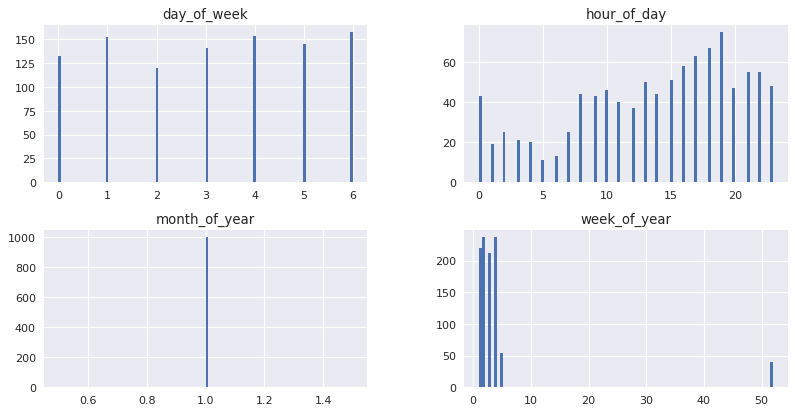

In [23]:
date_cols = ['hour_of_day', 'day_of_week', 'week_of_year', 'month_of_year']
sample_df[date_cols].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea466d5d68>,
      dtype=object)

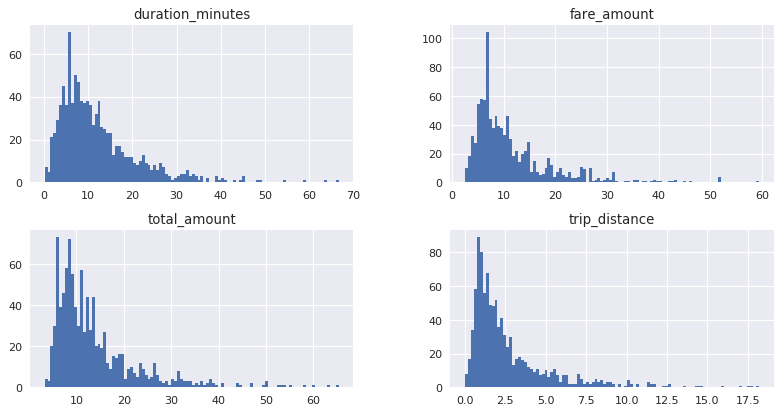

In [24]:
cost_cols =  ['total_amount', 'fare_amount', 'duration_minutes', 'trip_distance']
sample_df[cost_cols].hist(bins=100)

See if there is a correlation between duration in minutes and trip distance

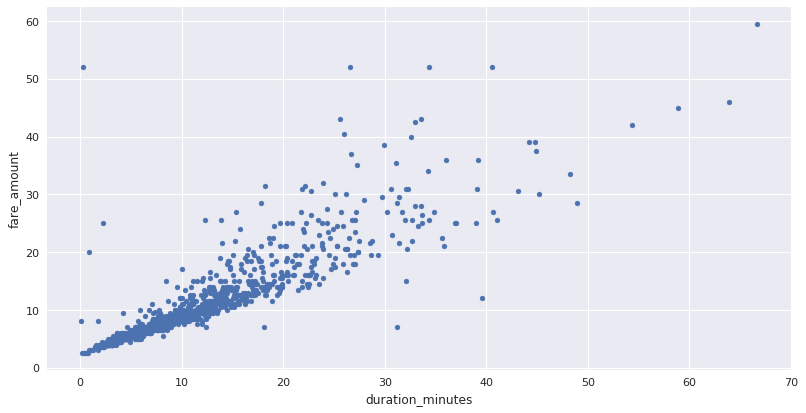

In [25]:
sample_df.plot.scatter(x='duration_minutes', y='fare_amount')

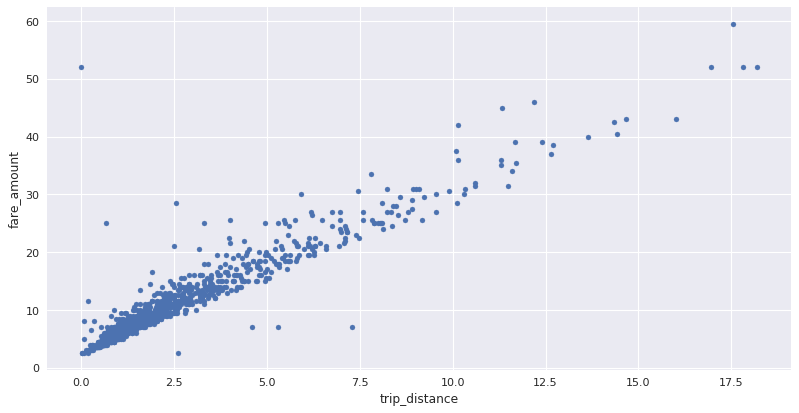

In [26]:
sample_df.plot.scatter(x='trip_distance', y='fare_amount')

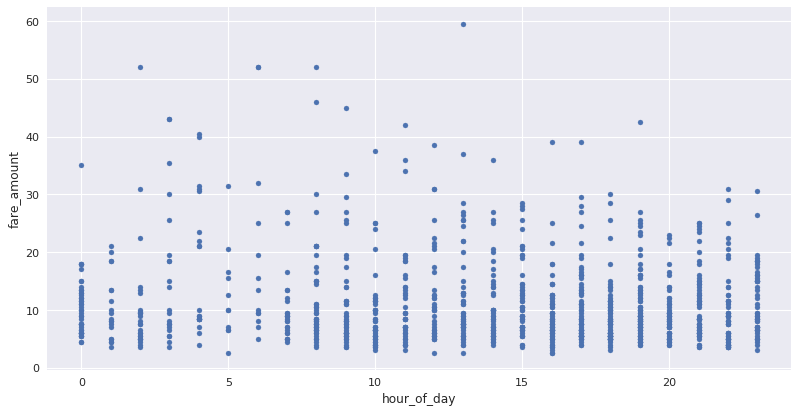

In [27]:
sample_df.plot.scatter(x='hour_of_day', y='fare_amount')

## Train Model

Build an XGBoost model to predict the total amount based on some fields

In [28]:
import boto3 
import sagemaker

sagemaker_session = sagemaker.session.Session(boto_session)
role = sagemaker.get_execution_role()
prefix = 'nyc-taxi'

print('bucket: {}, prefix: {}'.format(bucket, prefix))

bucket: sagemaker-us-east-1-769203131176, prefix: nyc-taxi


In [29]:
# Trip test split
from sklearn.model_selection import train_test_split

train_cols = ['total_amount', 'duration_minutes', 'trip_distance', 'hour_of_day']
train_df, val_df = train_test_split(data_df[train_cols], test_size=0.20, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.50, random_state=42)

print('split train: {}, val: {}, test: {} '.format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))

split train: 837104, val: 104638, test: 104639 


In [30]:
# Reset index and save files with target as first column
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

### Upload Data

Save train and validation as CSV with `total_amount` as first col but no headers

In [31]:
# Drop the tpep_pickup_datetime and save
train_df.to_csv('train.csv', index=False, header=False)
val_df.to_csv('validation.csv', index=False, header=False)

In [32]:
%%time

# Uplaod the files to s3 
s3_train_uri = sagemaker_session.upload_data('train.csv', bucket, prefix + '/data/training')
s3_val_uri = sagemaker_session.upload_data('validation.csv', bucket, prefix + '/data/validation')

CPU times: user 241 ms, sys: 24.3 ms, total: 265 ms
Wall time: 682 ms


Validate that we have uploaded these files succesfully

In [33]:
!aws s3 ls $s3_train_uri 
!aws s3 ls $s3_val_uri

2020-10-05 07:22:28   22028376 train.csv
2020-10-05 07:22:28    2756271 validation.csv


### Get estimator

In [34]:
container = sagemaker.image_uris.retrieve(region=region, framework="xgboost", version="latest")
print('container: {}'.format(container))

container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest


In [35]:
output_path = 's3://{}/{}/output'.format(bucket, prefix)
print('output: {}'.format(output_path))

xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    instance_count=1,
                                    instance_type='ml.m4.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sagemaker_session)

output: s3://sagemaker-us-east-1-769203131176/nyc-taxi/output


In [36]:
xgb.set_hyperparameters(max_depth=9,
                        eta=0.2, 
                        gamma=4,
                        min_child_weight=300,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=10000)

s3_input_train = sagemaker.inputs.TrainingInput(s3_data=s3_train_uri, content_type="csv")
s3_input_val = sagemaker.inputs.TrainingInput(s3_data=s3_val_uri, content_type="csv")

xgb.fit({'train': s3_input_train,  'validation': s3_input_val})

2020-10-05 07:22:31 Starting - Starting the training job...
2020-10-05 07:22:33 Starting - Launching requested ML instances......
2020-10-05 07:23:37 Starting - Preparing the instances for training......
2020-10-05 07:24:33 Downloading - Downloading input data...
2020-10-05 07:25:27 Training - Training image download completed. Training in progress..Arguments: train
[2020-10-05:07:25:28:INFO] Running standalone xgboost training.
[2020-10-05:07:25:28:INFO] File size need to be processed in the node: 23.64mb. Available memory size in the node: 8470.35mb
[2020-10-05:07:25:28:INFO] Determined delimiter of CSV input is ','
[07:25:28] S3DistributionType set as FullyReplicated
[07:25:28] 837104x3 matrix with 2511312 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-10-05:07:25:28:INFO] Determined delimiter of CSV input is ','
[07:25:28] S3DistributionType set as FullyReplicated
[07:25:28] 104638x3 matrix with 313914 entries loaded from /opt/ml/input/data

### Deploy model

In [37]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

----------------!

### Evalulate Model

Get predicitons for the validation set

In [38]:
from sagemaker.serializers import CSVSerializer
xgb_predictor.serializer = CSVSerializer()

In [39]:
%%time

import numpy as np
from tqdm import tqdm

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in tqdm(split_array):
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

# Get predictions and store in df
predictions = predict(val_df[train_cols[1:]].values)
predictions = pd.DataFrame({'total_amount_predictions': predictions })

100%|██████████| 210/210 [00:04<00:00, 47.18it/s]

CPU times: user 1.44 s, sys: 27.9 ms, total: 1.47 s
Wall time: 4.48 s


In [40]:
# Get the abs error between predictions
pred_df = val_df.join(predictions)
pred_df['error'] = abs(pred_df['total_amount']-pred_df['total_amount_predictions'])
pred_df.sort_values('error', ascending=False).head(10)

,total_amount,duration_minutes,trip_distance,hour_of_day,total_amount_predictions,error
66480,153.90,4.816667,0.15,19,8.702184,145.197816
50009,150.00,0.150000,0.22,18,16.747419,133.252581
34759,5.71,98.416667,43.14,4,105.205437,99.495437
34665,110.50,0.300000,3.80,2,14.229259,96.270741
52665,118.30,24.100000,5.50,9,24.225283,94.074717
19784,150.00,49.600000,16.20,13,57.131344,92.868656
23319,92.30,1.750000,0.37,13,4.827808,87.472192
65068,102.30,17.700000,2.47,17,15.651504,86.648496
86666,90.00,0.633333,1.10,0,10.812490,79.187510
20528,99.80,24.133333,4.47,11,21.432755,78.367245


Print the `RMSE` validation metric

In [41]:
from math import sqrt
from sklearn.metrics import mean_squared_error

def rmse(pred_df):
    return sqrt(mean_squared_error(pred_df['total_amount'], pred_df['total_amount_predictions']))

rmse(pred_df)

2.9228032074111385

Visualse the outlines vs predicted values

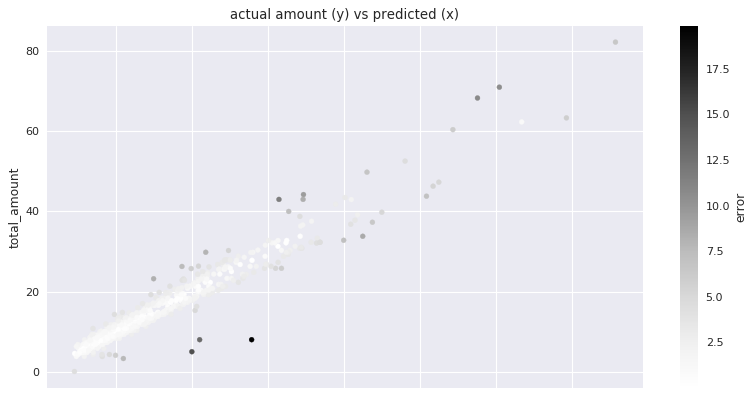

In [42]:
pred_df.tail(1000).plot.scatter(x='total_amount_predictions', y='total_amount', c='error', title='actual amount (y) vs predicted (x)')

## Create Athena UDF 

Create a [User Defined Function](https://aws.amazon.com/blogs/big-data/prepare-data-for-model-training-and-invoke-machine-learning-models-with-amazon-athena/) for the deployed endpoint so you can query directly in Athena.

In [43]:
endpoint_name = xgb_predictor.endpoint_name
print('endpoint: {}'.format(endpoint_name))

endpoint: xgboost-2020-10-05-07-26-14-399


`NOTE`: Athena ML is [in preview](https://aws.amazon.com/athena/faqs/#Preview_features).   To enable this Preview feature you need to create an Athena workgroup named `AmazonAthenaPreviewFunctionality` and run any queries attempting to federate to this connector, use a UDF, or SageMaker inference from that workgroup.

In [44]:
workgroup_name = 'AmazonAthenaPreviewFunctionality'

!aws athena create-work-group --name $workgroup_name --region $region


An error occurred (InvalidRequestException) when calling the CreateWorkGroup operation: WorkGroup AmazonAthenaPreviewFunctionality is already created


Using presto [datetime](https://prestodb.io/docs/0.172/functions/datetime.html) functions with inline query, rank by absolute error.

In [45]:
query_sql  = '''
USING FUNCTION predict_total(
  duration_minutes DOUBLE, 
  trip_distance DOUBLE, 
  hour_of_day DOUBLE) returns DOUBLE type SAGEMAKER_INVOKE_ENDPOINT
WITH (sagemaker_endpoint='{}')

SELECT 
    *, ABS(predicted_total_amount-total_amount) as error
FROM ( 
    SELECT
        *,
        predict_total(duration_minutes, trip_distance, hour_of_day) as predicted_total_amount
    FROM 
    (
        SELECT 
            total_amount,
            CAST(date_diff('minute', 
                CAST(lpep_pickup_datetime as timestamp), 
                CAST(lpep_dropoff_datetime as timestamp)) as DOUBLE) as duration_minutes,
            CAST(trip_distance as DOUBLE) as trip_distance,
            CAST(hour(CAST(lpep_pickup_datetime as timestamp)) as double) as hour_of_day
        FROM {}
        WHERE DAY(CAST(lpep_pickup_datetime as timestamp)) = {} -- Filter by day
    )
)
ORDER BY error DESC
LIMIT {};
'''.format(endpoint_name, table_name, 1, 10)
print('Querying...', query_sql)

query_df = cursor.execute(query_sql, work_group=workgroup_name).as_pandas()
print('Status: {}, Run time: {:.2f}s, Data scanned: {:.2f}MB, Records: {:,}'.format(cursor.state, 
    cursor.execution_time_in_millis/1000.0, cursor.data_scanned_in_bytes/1024.0/1024.0, query_df.shape[0]))

query_df

Querying... 
USING FUNCTION predict_total(
  duration_minutes DOUBLE, 
  trip_distance DOUBLE, 
  hour_of_day DOUBLE) returns DOUBLE type SAGEMAKER_INVOKE_ENDPOINT
WITH (sagemaker_endpoint='xgboost-2020-10-05-07-26-14-399')

SELECT 
    *, ABS(predicted_total_amount-total_amount) as error
FROM ( 
    SELECT
        *,
        predict_total(duration_minutes, trip_distance, hour_of_day) as predicted_total_amount
    FROM 
    (
        SELECT 
            total_amount,
            CAST(date_diff('minute', 
                CAST(lpep_pickup_datetime as timestamp), 
                CAST(lpep_dropoff_datetime as timestamp)) as DOUBLE) as duration_minutes,
            CAST(trip_distance as DOUBLE) as trip_distance,
            CAST(hour(CAST(lpep_pickup_datetime as timestamp)) as double) as hour_of_day
        FROM nyc_taxi.taxi_csv
        WHERE DAY(CAST(lpep_pickup_datetime as timestamp)) = 1 -- Filter by day
    )
)
ORDER BY error DESC
LIMIT 10;

Status: SUCCEEDED, Run time: 3.63s, Data sc

,total_amount,duration_minutes,trip_distance,hour_of_day,predicted_total_amount,error
0,240.00,0.0,0.00,4.0,17.986885,222.013115
1,276.64,49.0,48.20,8.0,97.970482,178.669518
2,140.80,1.0,0.20,10.0,4.547981,136.252019
3,203.16,43.0,38.59,11.0,96.603233,106.556767
4,7.00,193.0,52.96,22.0,105.352936,98.352936
5,-68.31,0.0,0.01,17.0,24.412111,92.722111
6,141.30,46.0,12.14,16.0,49.993526,91.306474
7,10.00,52.0,26.49,7.0,97.263237,87.263237
8,104.00,0.0,0.00,6.0,17.737371,86.262629
9,-60.00,0.0,0.00,19.0,22.818607,82.818607
